In [ ]:
import matplotlib.pyplot as plt
import neqsim.thermo
import numpy as np
import os
import pandas as pd


from datetime import datetime
from neqsim.thermo import TPflash
from neqsim.thermo.thermoTools import dataFrame, jNeqSim
from typing import Dict

plt.style.use("seaborn-v0_8-paper")
plt.style.use(os.path.join("src", "visualization", "styles", "l3_mod.mplstyle"))

np.set_printoptions(precision=4, suppress=True)

## Referências (NeqSim)

- https://github.com/equinor/neqsim-python
- https://github.com/equinor/neqsim-python/tree/master/examples
- https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=kHt6u-utpvYf

In [2]:
COMPONENTS = {
    "zN2": "nitrogen",
    "zCO2": "CO2",
    "zC1": "methane",
    "zC2": "ethane",
    "zC3": "propane",
    "zIC4": "i-butane",
    "zNC4": "n-butane",
    "zIC5": "i-pentane",
    "zNC5": "n-pentane",
    "zC6": "n-hexane",
    "zC7": "n-heptane",
    "zC8": "n-octane",
    "zC9": "n-nonane",
    "zC10": "nC10",
    "zC11": "nC11",
    "zC12": "nC12",
    "zC13": "nC13",
    "zC14": "nC14",
    "zC15": "nC15",
    "zC16": "nC16",
    "zC17": "nC17",
    "zC18": "nC18",
    "zC19": "nC19",
    "zC20": "nC20",
}

processed_data = pd.read_csv("data\\processed\\processed_data.csv")
composition_data = processed_data.loc[:, processed_data.columns.str.contains("z")]

def set_components(composition: Dict[str, float]):
    fluid = neqsim.thermo.fluid("pr")
    for component, fraction in composition.items():
        fluid.addComponent(COMPONENTS[component], fraction)
    fluid.setMixingRule("classic")  # classic will use binary kij
    return fluid

processed_data.head()

,Field,Id,Date,FluidKind,LastFluidMolecularWeight,LastFluidSpecificGravity,zN2,zCO2,zC1,zC2,...,zC12,zC13,zC14,zC15,zC16,zC17,zC18,zC19,zC20,LastFluidComponent
0,Albacora,2.005888e+38,28/11/2013,OLEO,513.0,0.9375,0.28,2.18,50.34,8.80,...,1.39,1.42,1.19,1.12,0.84,0.75,0.74,0.71,7.54,C20
1,Albacora,2.356551e+38,28/11/2013,OLEO,513.0,0.9375,0.28,2.18,50.34,8.80,...,1.39,1.42,1.19,1.12,0.84,0.75,0.74,0.71,7.54,C20
2,Albacora,2.850025e+36,11/12/2014,OLEO,447.0,0.9332,0.36,3.23,45.32,7.16,...,1.35,1.40,1.13,1.07,0.83,0.68,0.74,0.67,10.99,C20
3,Albacora,6.682053e+37,11/12/2014,OLEO,447.0,0.9332,0.36,3.23,45.32,7.16,...,1.35,1.40,1.13,1.07,0.83,0.68,0.74,0.67,10.99,C20
4,Albacora,3.215674e+38,01/08/2007,OLEO,428.0,0.9508,0.01,0.17,42.67,5.08,...,1.44,1.48,1.30,1.30,1.00,0.86,0.84,0.75,24.57,C20


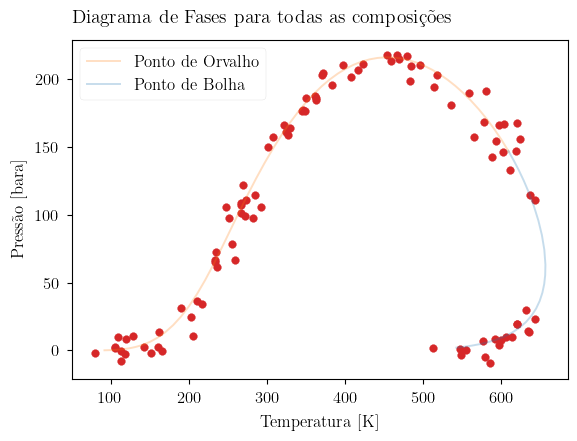

In [43]:
for i in np.arange(processed_data.shape[0]):
    fluid1 = set_components(composition_data.loc[i, :].to_dict())
    thermoOps = jNeqSim.thermodynamicOperations.ThermodynamicOperations(fluid1)
    thermoOps.calcPTphaseEnvelope(True, 0.1)

    if 0.0 in list(thermoOps.getOperation().get("dewT")):
        # print(processed_data.loc[i, :].to_dict())
        thermoOps.calcPTphaseEnvelope(False, 0.1)
        if 0.0 in list(thermoOps.getOperation().get("dewT")):
            composition_data = composition_data.drop(i)
            processed_data = processed_data.drop(i)
            continue

    dewP = np.array(thermoOps.getOperation().get("dewP"))[:-1]
    bubP = np.array(thermoOps.getOperation().get("bubP"))
    envelopeP = np.r_[dewP, bubP]

    dewT = np.array(thermoOps.getOperation().get("dewT"))[:-1]
    bubT = np.array(thermoOps.getOperation().get("bubT"))
    envelopeT = np.r_[dewT, bubT]

    probs = np.abs(np.diff(envelopeT))
    probs /= probs.sum()

    for _ in range(100):
        index = np.random.choice(np.arange(1, envelopeT.shape[0]), p=probs)
        T_range = np.array([envelopeT[index - 1], envelopeT[index]])
        P_range = np.array([envelopeP[index - 1], envelopeP[index]])

        T_center = (T_range[1] - T_range[0]) * np.random.random() + T_range[0]
        P_center = np.interp(T_center, T_range, P_range)

        noiseP = 0.025 * (envelopeP.max() - envelopeP.min()) * np.random.normal()
        noiseT = 0.025 * (envelopeT.max() - envelopeT.min()) * np.random.normal()
        plt.scatter(T_center + noiseT, P_center + noiseP, color="tab:red")

    plt.plot(
        list(thermoOps.getOperation().get("dewT")),
        list(thermoOps.getOperation().get("dewP")),
        label="Ponto de Orvalho",
        alpha=0.25,
        color="tab:orange",
    )
    plt.plot(
        list(thermoOps.getOperation().get("bubT")),
        list(thermoOps.getOperation().get("bubP")),
        label="Ponto de Bolha",
        alpha=0.25,
        color="tab:blue",
    )
    break

plt.title("Diagrama de Fases para todas as composições", loc="left")
plt.xlabel("Temperatura [K]")
plt.ylabel("Pressão [bara]")
plt.legend()
# plt.savefig("phase_diagrams.png", dpi=600)
plt.show()

# composition_data = composition_data.reset_index(drop=True)
# processed_data = processed_data.reset_index(drop=True)

In [ ]:
data = []
fluids = []

composition = composition_data.loc[0, :].to_dict()
print(composition_data.loc[0, :].to_list())

mix_fluids = []
for sample_i in np.arange(TP.shape[0]):
    outputs = {}
    fluid = set_components(composition)

    T, P = TP[sample_i, 0], TP[sample_i, 1]
    fluid.setTemperature(T)
    fluid.setPressure(P)

    # start = datetime.now()
    TPflash(fluid)
    # print(f"elapsed time: {datetime.now() - start}")

    outputs["NumberOfPhases"] = fluid.getNumberOfPhases()
    components = [c for c in fluid.getComponentNames()]
    phases = [p for p in fluid.getPhases() if p]
    outputs["Phases"] = ",".join([str(phase.getPhaseTypeName()) for phase in phases])
    outputs["P [bara]"] = fluid.getPressure()
    outputs["T [degC]"] = fluid.getTemperature()

    if fluid.getNumberOfPhases() == 2:
        for phase in phases:
            for component in components:
                phase_name = phase.getPhaseTypeName()
                phase_var = ""
                # outputs[f"{phase_name}_{component}"] = phase.getComponent(component).getx()
    data.append(outputs)
    fluids.append(fluid)

flash = pd.DataFrame.from_records(data)
flash.head()     

In [ ]:
from IPython.display import display

print({phases: count for phases, count in zip(*np.unique(flash["Phases"], return_counts=True))})

flash[flash["Phases"] == "gas,oil"]

In [ ]:
outputs = []
for i in flash[flash["Phases"] == "gas,oil"].index:
    raw_results = dataFrame(fluids[i])

    results = (
        raw_results.replace("", np.nan)
        .dropna(how="all")
        .iloc[1:-3, [0, 1, 2, 3]]
        .set_index(0)
        .apply(lambda serie: pd.to_numeric(serie))
    )
    results.index.name = "Component"
    results.columns = ["z", "y", "x"]

    # Phase Fractions
    nV = results.at["Phase Fraction", "y"]
    nL = results.at["Phase Fraction", "x"]

    # Phase Component Fractions
    phases_fractions = results.iloc[:24, :].copy()
    phases_fractions.index = [f"K_{c[1:]}" for c in COMPONENTS.keys()]

    z = phases_fractions["z"]
    x = phases_fractions["x"]
    phases_fractions.loc[:, "K"] = (z - x * nL) / (nV * x)

    output = phases_fractions.T.loc["K", :].to_dict()
    output["nV"] = nV
    outputs.append(output)

outputs = pd.DataFrame.from_records(outputs)
outputs.columns